#  Student Exam Scores Prediction

#### In this notebook:

1. Exploratory Data Analysis will be performed to figure out features with the most correlation to student exam scores. 

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from src.preprocess import load_data, cap_scores, fill_null_values, select_features, select_target, scale_features

In [2]:
df = load_data('../data/students_performance.zip')

## EDA

In [3]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [4]:
X = df.iloc[:, :-1]
X.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female


As we can see, there's plenty of features. We'll do some correlation tests to reduce dimensionality for better performance later.

But before that, let's take a look whether the exam scores are evenly distributed.

### Target variable distribution

count    6607.000000
mean       67.235659
std         3.890456
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: Exam_Score, dtype: float64


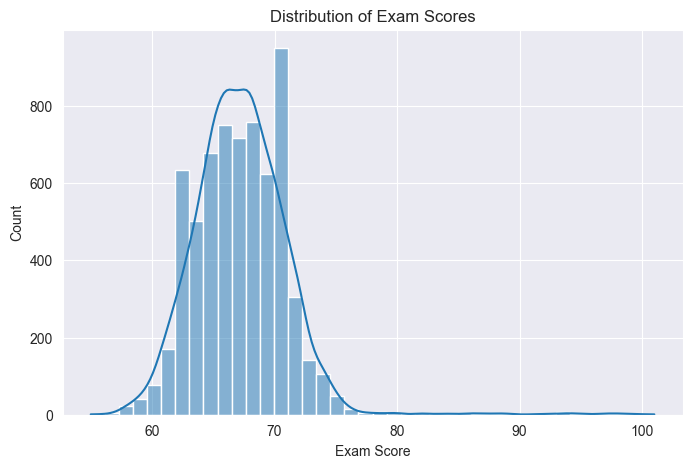

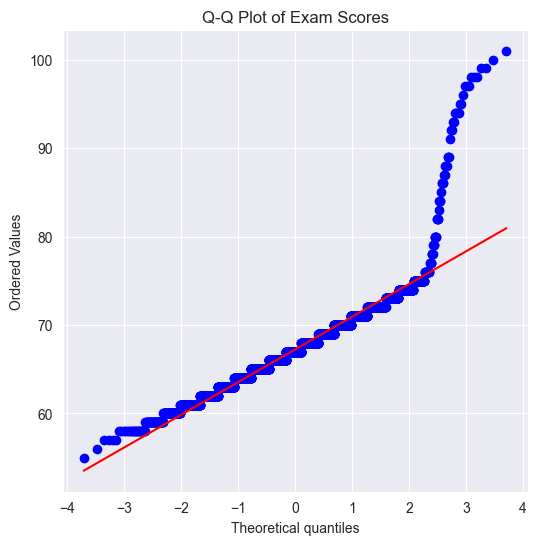

In [5]:
y = df['Exam_Score']

print(y.describe())

plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True, bins=40)
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(y, dist='norm', plot=plt)
plt.title('Q-Q Plot of Exam Scores')
plt.show()

#### As we can see:
1. The data pretty much follows the normal distribution in the middle-range (say from the 20th to 80th percentile), however there are some outliers in the lower end, and much more on the higher end.
2. Exam scores range between 55 and 101 points. Most likely, the 101 is an error, so I will ceil those values to 100 next.
3. Majority of students fall in the 60-75 range. 
4. Students with scores lower than 60 could be considered underperformers, and might be of interest to their teachers for early exam fail prevention.

In [6]:
df = cap_scores(df, 100)

print(df['Exam_Score'].describe())

count    6607.000000
mean       67.235508
std         3.889161
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       100.000000
Name: Exam_Score, dtype: float64


## Data Quality & Completeness

In [7]:
# Checking for null values :D

missing_cnt   = df.isna().sum()
missing_pct   = (df.isna().mean() * 100).round(2)
missing_table = pd.concat([missing_cnt, missing_pct], axis=1, keys=['missing_count','percent_missing'])
print(missing_table)

                            missing_count  percent_missing
Hours_Studied                           0             0.00
Attendance                              0             0.00
Parental_Involvement                    0             0.00
Access_to_Resources                     0             0.00
Extracurricular_Activities              0             0.00
Sleep_Hours                             0             0.00
Previous_Scores                         0             0.00
Motivation_Level                        0             0.00
Internet_Access                         0             0.00
Tutoring_Sessions                       0             0.00
Family_Income                           0             0.00
Teacher_Quality                        78             1.18
School_Type                             0             0.00
Peer_Influence                          0             0.00
Physical_Activity                       0             0.00
Learning_Disabilities                   0             0.

Teacher_Quality, Parental_Education_Level and Distance_from_Home can be null from time to time

As the number of missing values isn't significant, we can fill them using .fillna, that won't have a huge effect on our results.  

All the missing values are categorical, so we'll use the mode here.

In [8]:
# Filling null values

null_cols = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

df = fill_null_values(df)

print(df[null_cols].isna().sum())

Teacher_Quality             0
Parental_Education_Level    0
Distance_from_Home          0
dtype: int64


In [9]:
# Checking for duplicates :)

dupe_count = df.duplicated().sum()
print(f"Number of exact duplicate rows: {dupe_count}")

Number of exact duplicate rows: 0


No duplicates, the data looks pretty good now

## Feature selection

As we have both numeric and categorical features, we will have to test them separately. 

#### Numeric features
We'll perform pearson's r (Linear Correlation) and Spearman’s ρ (Rank Correlation) tests here.

In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Exam_Score')

pearson_corr = df[num_cols + ['Exam_Score']].corr(method='pearson')['Exam_Score'] \
                  .drop('Exam_Score') \
                  .abs() \
                  .sort_values(ascending=False)
print("Top Pearson correlations with Exam_Score:\n", pearson_corr.head(10))


Top Pearson correlations with Exam_Score:
 Attendance           0.581205
Hours_Studied        0.445558
Previous_Scores      0.175089
Tutoring_Sessions    0.156466
Physical_Activity    0.027832
Sleep_Hours          0.017000
Name: Exam_Score, dtype: float64


In [11]:
spearman_corr = df[num_cols + ['Exam_Score']].corr(method='spearman')['Exam_Score'] \
                    .drop('Exam_Score') \
                    .abs() \
                    .sort_values(ascending=False)
print("\nTop Spearman correlations with Exam_Score:\n", spearman_corr.head(10))


Top Spearman correlations with Exam_Score:
 Attendance           0.672366
Hours_Studied        0.480956
Previous_Scores      0.191941
Tutoring_Sessions    0.163940
Physical_Activity    0.029150
Sleep_Hours          0.007629
Name: Exam_Score, dtype: float64


Attendance and Hours studied have huge correlation with exam scores on both tests, so we'll definitely keep those. 

The other features don't seem significant enough.

#### Categorical features

We'll perform an ANOVA F test to pick the most significant features

The features will be "One-hot encoded", which means a feature with K categories will be transformed into K boolean features



e.g. before:

* Access_to_Resources -> Low/Medium/High

after:

* Access_to_Resources_Low -> True/False

* Access_to_Resources_Medium -> True/False

* Access_to_Resources_High -> True/False


P.S. I explicitly didn't drop any columns in the encoding here to check for significance among all feature values


In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing    import OneHotEncoder
from sklearn.compose          import ColumnTransformer

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

pre = ColumnTransformer([
    ('ohe', OneHotEncoder(drop=None), cat_cols)
], remainder='drop')

X_cat_ohe = pd.DataFrame(
    pre.fit_transform(df),
    columns=pre.get_feature_names_out()
)

selector = SelectKBest(f_regression, k=14)
selector.fit(X_cat_ohe, df['Exam_Score'])

f_scores = pd.Series(selector.scores_, index=X_cat_ohe.columns)
print("Top categorical features by F-score:\n", f_scores.sort_values(ascending=False).head(14))

Top categorical features by F-score:
 ohe__Access_to_Resources_High                 139.542252
ohe__Parental_Involvement_High                132.947133
ohe__Access_to_Resources_Low                  117.450124
ohe__Parental_Involvement_Low                  86.532715
ohe__Parental_Education_Level_Postgraduate     58.647910
ohe__Peer_Influence_Negative                   52.219362
ohe__Parental_Education_Level_High School      50.516698
ohe__Learning_Disabilities_No                  48.160459
ohe__Learning_Disabilities_Yes                 48.160459
ohe__Family_Income_Low                         44.735325
ohe__Peer_Influence_Positive                   43.834508
ohe__Distance_from_Home_Near                   43.629910
ohe__Motivation_Level_Low                      42.679778
ohe__Family_Income_High                        38.363049
dtype: float64


Woah! That's a lot of correlation here. My features of choice here are:
* Access_to_Resources
* Parental_Involvement
* Parental_Education_Level 
* Peer_Influence
* Learning_Disabilities

Now the confusing part. We will have to keep k-1 columns for each feature, where k is feature's categories count. K-1 cause that one category can be identified as "neither". e.g. When all other categories are 0 

In [13]:
cat_cols = [
    'Access_to_Resources',
    'Parental_Involvement',
    'Parental_Education_Level',
    'Peer_Influence',
    'Learning_Disabilities'
]
num_cols = ['Attendance', 'Hours_Studied']

X = select_features(df, cat_cols, num_cols)
y = select_target(df, 'Exam_Score')

X.head()

,Attendance,Hours_Studied,Access_to_Resources_Low,Access_to_Resources_Medium,Parental_Involvement_Low,Parental_Involvement_Medium,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes
0,84,23,False,False,True,False,True,False,False,True,False
1,64,19,False,True,True,False,False,False,False,False,False
2,98,24,False,True,False,True,False,True,True,False,False
3,89,29,False,True,True,False,True,False,False,False,False
4,92,19,False,True,False,True,False,False,True,False,False


In [14]:
y.head()

0    67
1    61
2    74
3    71
4    70
Name: Exam_Score, dtype: int64

#### Feature scaling


We have 11 features, which is quite a lot. Hopefully our algorithms will be able to handle that :)
    
To help them a little, lets scale the numeric features.

In [15]:
num_cols = ['Attendance', 'Hours_Studied']

X = scale_features(X)
X.head()

,Attendance,Hours_Studied,Access_to_Resources_Low,Access_to_Resources_Medium,Parental_Involvement_Low,Parental_Involvement_Medium,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes
0,0.348375,0.504942,False,False,True,False,True,False,False,True,False
1,-1.383736,-0.162822,False,True,True,False,False,False,False,False,False
2,1.560853,0.671882,False,True,False,True,False,True,True,False,False
3,0.781403,1.506587,False,True,True,False,True,False,False,False,False
4,1.041220,-0.162822,False,True,False,True,False,False,True,False,False
